# 宏观因子资产配置研究

更新日志
- 2022.10.22 
  - 梳理工作内容并搭建研究框架
- 10.24
  - 计算因子暴露和因子模拟组合

当前问题
- 10.24
  - 检查因子模拟组合时，按照论文中的公式计算后不是零和投资组合
  - $ P=[B'\Sigma^{-1}B]^{-1}B'\Sigma^{-1} $

In [1]:
import os, sys, argparse, logging

# 设置logging格式和级别
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO, 
    format='%(filename)s-line%(lineno)d %(levelname)s: %(message)s'
    )

logging.disable(logging.DEBUG)
logging.disable(logging.INFO)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy

logging.disable(logging.NOTSET)

# 首先将framework的目录加进sys.path中，方便使用相对路径导入
framework_path = os.path.join(os.path.abspath(''), '../../../../国君研究所/工作/FOF_portfolio_toolbox/framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *


init YamlSvc
init DateSvc
init YamlSvc
init ConstantSvc


In [2]:
from component.asset.asset import Asset
from backtest_manager.backtest_manager import BackTestManager

from import_func import getSvc
date_svc = getSvc('DateSvc')
constant_svc = getSvc('ConstantSvc')


## 1. 选择待研究的大类资产(国内大类资产)

|No.    |资产类别       |资产标的       |权重约束   |
|--     |--             |--            |--         |
|1      |大市值股票     |沪深300指数     ||
|2      |中小市值股票   |中证500指数	  | |
|3      |利率债         |中债国债总指数  ||
|4      |信用债         |中债信用债总指数|	|
|5      |商品	        |南华综合指数	||
|6      |黄金	        |Au9999	||

### 1.1 读入资产原始数据
所有数据存放在../data/assets中

In [3]:
# 读入资产原始数据
asset_raw_data_path = os.path.join(this_path, '../data/assets')
asset_dict = {}
for file_name in os.listdir(asset_raw_data_path):
    # 读入原始数据
    asset_name = file_name.split('.')[0]
    raw_data = pd.read_excel(os.path.join(asset_raw_data_path,file_name), index_col=0)
    raw_nav_data = raw_data['收盘价']
    raw_nav_data.index.name = 'date'
    
    # 创建资产实体并加入dict
    asset_obj = Asset(asset_name)
    asset_obj.setRawNavData(raw_nav_data)
    
    asset_dict[asset_name] = asset_obj

print(asset_dict)

date_svc.setTradeDays(raw_nav_data.index)

date_svc.py-line31 INFO: DateSvc: set trade days


{'Au9999': <component.asset.asset.Asset object at 0x000001D9F59982B0>, '中债信用债总指数': <component.asset.asset.Asset object at 0x000001D9F5CC4DC0>, '中债国债总指数': <component.asset.asset.Asset object at 0x000001D9F5E46A30>, '中证500指数': <component.asset.asset.Asset object at 0x000001D9F6095460>, '南华综合指数': <component.asset.asset.Asset object at 0x000001D9F5ADCFA0>, '沪深300指数': <component.asset.asset.Asset object at 0x000001D9F5D64A90>}


## 2. 构造宏观因子组合

### 2.1 读入因子原始数据

In [4]:
# 载入因子
from symbol import factor


factor_raw_data_path = os.path.join(this_path, '../data/factors')
factor_dict = {}
for file_name in os.listdir(factor_raw_data_path):
    # 读入原始数据
    factor_name = file_name.split('.')[0]
    raw_data = pd.read_excel(os.path.join(factor_raw_data_path,file_name), index_col=0)
    raw_data.index.name = 'date'
    raw_data = raw_data.iloc[:, 0]

    # 去除第一行空值, 去除0值防止除0错误
    raw_data = raw_data.iloc[1:]
    raw_data.loc[raw_data==0] = 1e-6

    # logging.debug(raw_data)
    
    # 创建因子实体并加入dict
    factor_obj = Asset(factor_name)
    factor_obj.setRawNavData(raw_data)
    
    factor_dict[factor_name] = factor_obj

print(factor_dict)

{'growth': <component.asset.asset.Asset object at 0x000001D9F6065250>, 'real': <component.asset.asset.Asset object at 0x000001D9F5F29070>}


### 2.2 因子模拟组合的构建和回测
构建因子模拟组合，使该组合只对某一个因子有暴露，检查回测结果

In [5]:
# 计算归一化因子暴露
factor_exposure_alg = FactorExposureAlg('factor_exposure_alg')
id_date = datetime(2017, 8, 31)

# 向前取多少数据用于计算
look_back = constant_svc.DAY_OF_YEAR

# 为资产和因子设置日期
for asset_obj in asset_dict.values():
    asset_obj.setIdDate(id_date, look_back)
for factor_obj in factor_dict.values():
    factor_obj.setIdDate(id_date, look_back)

asset_data = {asset: asset_obj.getUsableReturnData() for asset, asset_obj in asset_dict.items()}
factor_data = {factor: factor_obj.getUsableNavData() for factor, factor_obj in factor_dict.items()}


alg_base.py-line19 INFO: alg factor_exposure_alg: init args


In [6]:
# v1 一元回归
exposure_df_v1 = factor_exposure_alg.getFatorExposureFrame(asset_data, factor_data)
print('exposure_df_v1:\n ', exposure_df_v1)

print('*' * 50)
# v2 多元回归
exposure_df_v2 = factor_exposure_alg.getFatorExposureFrameV2(asset_data, factor_data)
print('exposure_df_v2:\n ', exposure_df_v2)


exposure_df_v1:
              growth      real
Au9999   -0.767473 -1.879083
中债信用债总指数 -0.705240  0.710735
中债国债总指数  -0.686809  0.884402
中证500指数   1.680095  0.259975
南华综合指数   -0.262417  0.250588
沪深300指数   0.741844 -0.226618
**************************************************
exposure_df_v2:
              growth      real
Au9999   -0.766915 -1.829462
中债信用债总指数 -0.705484  0.769370
中债国债总指数  -0.687106  0.942533
中证500指数   1.680070  0.130737
南华综合指数   -0.262503  0.272332
沪深300指数   0.741939 -0.285509


In [7]:
factor_portfolio_alg = FactorPortfolioAlg('factor_portfolio_alg')

factor_mimicking_portfolio_v1 = factor_portfolio_alg.getFactorMimickingPortfolio(asset_data, factor_data, ols_mode='v1')
print('factor_mimicking_portfolio_v1: \n', factor_mimicking_portfolio_v1)
print(factor_mimicking_portfolio_v1.sum())

print('*' * 50)

factor_mimicking_portfolio_v2 = factor_portfolio_alg.getFactorMimickingPortfolio(asset_data, factor_data, ols_mode='v2')
print('factor_mimicking_portfolio_v2: \n', factor_mimicking_portfolio_v2)
print(factor_mimicking_portfolio_v2.sum())


alg_base.py-line19 INFO: alg factor_portfolio_alg: init args
alg_base.py-line19 INFO: alg : init args


factor_mimicking_portfolio_v1: 
             growth      real
Au9999   -0.229367 -0.248923
中债信用债总指数 -1.858627 -0.350059
中债国债总指数   0.943786  0.814722
中证500指数   0.132363  0.123459
南华综合指数    0.013281  0.012960
沪深300指数  -0.077521 -0.111049
growth   -1.076085
real      0.241110
dtype: float64
**************************************************
factor_mimicking_portfolio_v2: 
             growth      real
Au9999   -0.248616 -0.247676
中债信用债总指数 -1.885683 -0.348779
中债国债总指数   1.006785  0.810699
中证500指数   0.141910  0.122846
南华综合指数    0.014283  0.012896
沪深300指数  -0.086108 -0.110485
growth   -1.057429
real      0.239501
dtype: float64


In [8]:
backtest_args = {
    'date_range': [[2016, 1, 1], [2020, 12, 31]], 
    'frequency': 'monthly', 
    'cash': 1e4, 
    }

In [9]:
factor_mimicking_portfolio_nav = pd.DataFrame()
asset_weight_dict = {}
for factor in factor_dict:
    asset_weight = pd.DataFrame()
    my_backtest_manager = BackTestManager(
        FactorMimickingPortfolioStrategy('test', factor), # 策略实例
        name = 'futures_trenf_following_backtest', 
        args = backtest_args, 
    )
    my_backtest_manager.backtest()
    factor_mimicking_portfolio_nav[factor] = my_backtest_manager.getDataset().getPositionManager().getHistoricalData().nav

    # 存储结果
    result = {
        'strategy': my_backtest_manager.getDataset().getPositionManager().getHistoricalData(), 
        'assets': my_backtest_manager.getDataset().getGroup('assets').getPositionManager().getHistoricalData(), 
        'orders': my_backtest_manager.getOrderManager().getAllOrders()
    }
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        result[asset] = asset_obj.getPositionManager().getHistoricalData()

    writer = pd.ExcelWriter(os.path.join(this_path, 'results.xlsx'))
    for k, v in result.items():
        print(k)
        v.to_excel(writer, k.replace('/', '-'))
    writer.save()
    writer.close()

    # sys.exit(1)

    # weight
    for asset, asset_obj in my_backtest_manager.getDataset().getAllAsset().items():
        asset_weight[asset] = asset_obj.getPositionManager().getHistoricalData().weight
    asset_weight_dict[factor] = asset_weight


alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1218/1218 [00:31<00:00, 39.20days/s]


strategy
assets
orders
cash
assets/Au9999
assets/中债信用债总指数
assets/中债国债总指数
assets/中证500指数
assets/南华综合指数
assets/沪深300指数


alg_base.py-line19 INFO: alg test: init args
alg_base.py-line19 INFO: alg _: init args
alg_base.py-line19 INFO: alg : init args
strategy_base.py-line49 INFO: strategy test: init dataset
backtest_manager.py-line26 INFO: init BackTestManager
backtest_manager.py-line61 INFO: setting date index
backtest_manager.py-line68 INFO: setting init cash
strategy_base.py-line64 INFO: test: init cash
backtest: 100%|██████████| 1218/1218 [00:31<00:00, 38.89days/s]


strategy
assets
orders
cash
assets/Au9999
assets/中债信用债总指数
assets/中债国债总指数
assets/中证500指数
assets/南华综合指数
assets/沪深300指数


<AxesSubplot:>

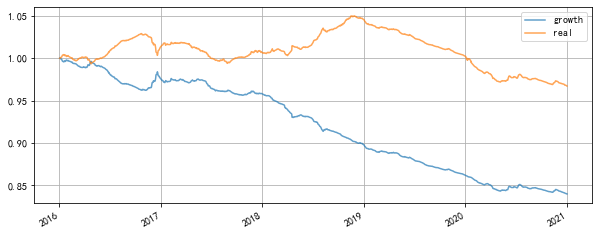

In [10]:
factor_mimicking_portfolio_nav.plot(figsize=(10,4), grid=True, alpha=0.7)

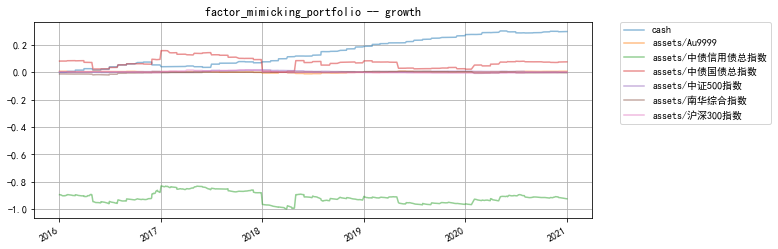

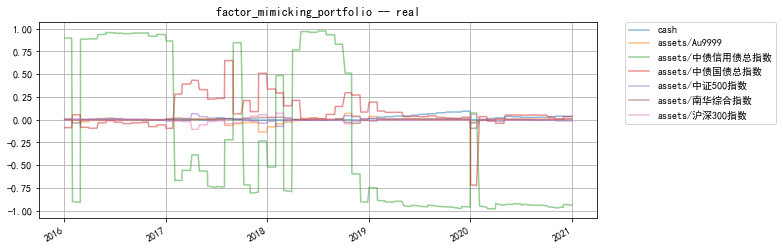

In [11]:
for factor, weights in asset_weight_dict.items():
    weights.plot(figsize=(10,4), grid=True, alpha=0.5, title='factor_mimicking_portfolio -- {}'.format(factor))
    plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.)

## 3. 配置因子VS配置资产（模型性能比较）